# Deep learning on Pickles

In this notebook we will use a deep learning approach to do stellar classification on the basis of spectra. For this we will use the Pickles library. Note that this is really too small to do a proper deep learning model but it should be sufficient to get a first start.

The library we will use is TensorFlow with the keras interface in Python. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline

2023-03-09 23:24:29.117595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Get the spectrum library

This will not work until you have installed matplotlib, pandas and astropy.

In [2]:
import PCA_pickles_driver as pp
from importlib import reload
reload(pp)

<module 'PCA_pickles_driver' from '/Users/jarle/Teaching/MLD2023/Lectures/Lecture 5/Notebooks/PCA_pickles_driver.py'>

In [4]:
wave, flux, dflux = pp.load_pickles_library()
t_overview = pp.load_overview_table()

We also want to limit our attention to the optical wavelength region

In [5]:
i_use, = np.where((wave>3000) & (wave < 10000))

flux_use = flux[i_use, :]
dflux_use = dflux[i_use, :]
wave_use = wave[i_use]

X = flux_use.T

## Dividing into test and training samples

This is a crucial step and it is important to do this right. Thus I use a `StratifiedShuffleSplit` which allows us to create a training sample that has the same relative number of examples in each class (here in each spectral class).

This does perhaps lead to overfitting at O & B where we have few examples.

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

In [7]:
label = np.round(t_overview['numtype'])
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
sss.get_n_splits(X, label )

#for train_index, test_index in sss.split(X, label):
#    print("TRAIN:", train_index, "TEST:", test_index)
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = label[train_index], label[test_index]

5

In [8]:
# Get one training set
tmp = sss.split(X, label)

The split using `StratifiedShuffleSplit` is a bit more complicated than other splitting functions. It returns an iterator and you need to first split (as above) and then you have to call `send` on the returned result.

In [9]:
i_train, i_test = tmp.send(None)

In [10]:
len(i_train), len(i_test)

(104, 27)

In [11]:
n_X, n_data = X.shape
n_train = len(i_train)
n_test = len(i_test)
n_X, n_data

(131, 1399)

## Set up the keras model

I will use a sequential model in Keras - this allows you to add the layers you want. So let us first do a single hidden layer. The first layer is dense and has 32 units.

In [12]:
model = Sequential()
model.add(Dense(n_data, input_dim=n_data, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='linear'))

2023-03-09 23:25:27.976537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model.compile(optimizer='Adam',
              loss='mse')
#,
#              metrics=['accuracy'])

In [14]:
t_overview.columns

<TableColumns names=('SPType','Lumclass','Metal','numtype','metflag','numlclass','file')>

In [15]:
#one_hot_labels = keras.utils.to_categorical(label[i_train], num_classes=70)

In [16]:
train_X = X[i_train, :]
train_y = label[i_train]
test_X = X[i_test, :]
test_y = label[i_test]

history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=150, verbose=0)

# history = model.fit(X[i_train, :], label[i_train], epochs=150, batch_size=32)

In [17]:
train_mse = model.evaluate(train_X, train_y, verbose=0)
test_mse = model.evaluate(test_X, test_y, verbose=0)
print("Train= {0}.  Test= {1}".format(train_mse, test_mse))

Train= 0.07989838719367981.  Test= 0.4449126422405243


dict_keys(['loss', 'val_loss'])


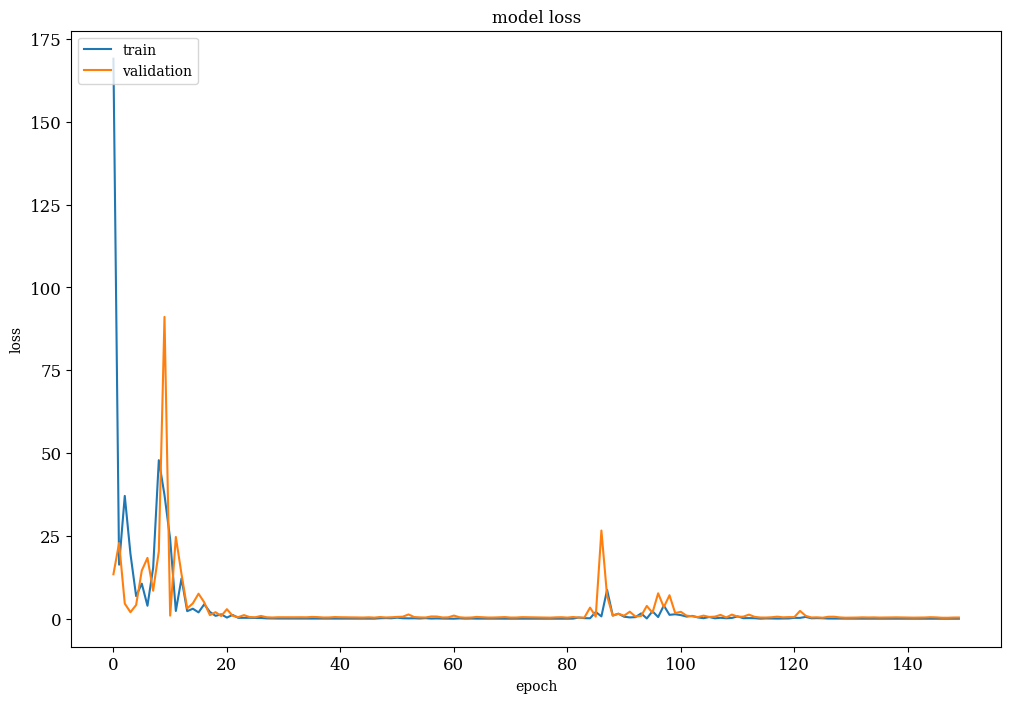

In [18]:
print(history.history.keys())
# Show loss
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')
# plt.show()

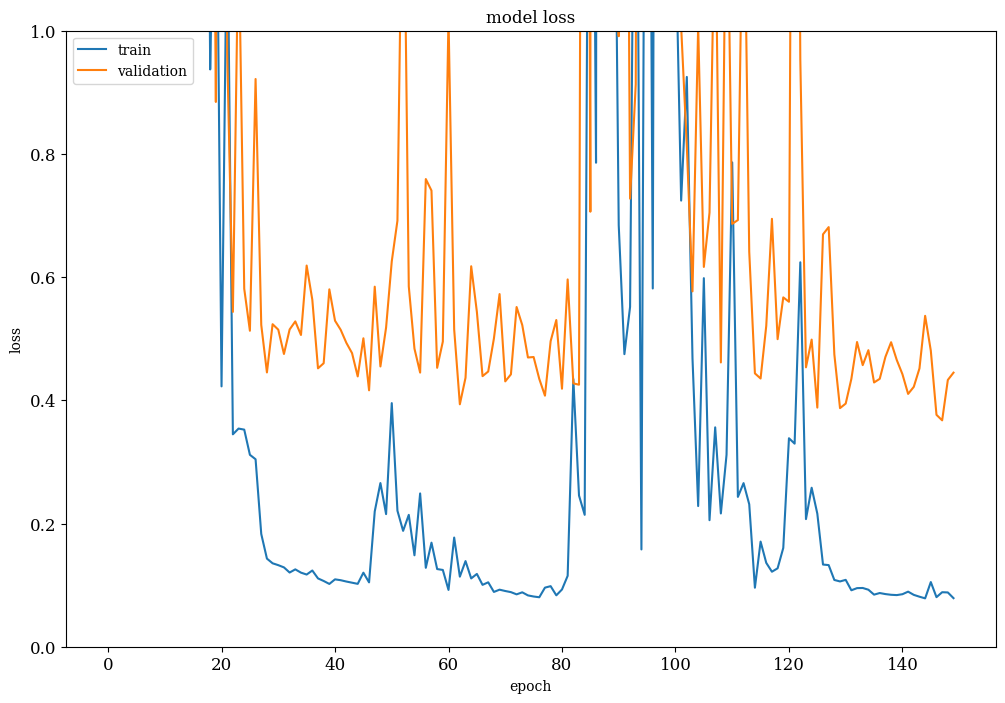

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_ylim(0, 1)
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper left')

## Comparing predicted to observed class

You get the predicted class from `model.predict` given the $X$ input data.


In [20]:
y_pred = model.predict(test_X)

1/1 [==============================] - 0s 86ms/step


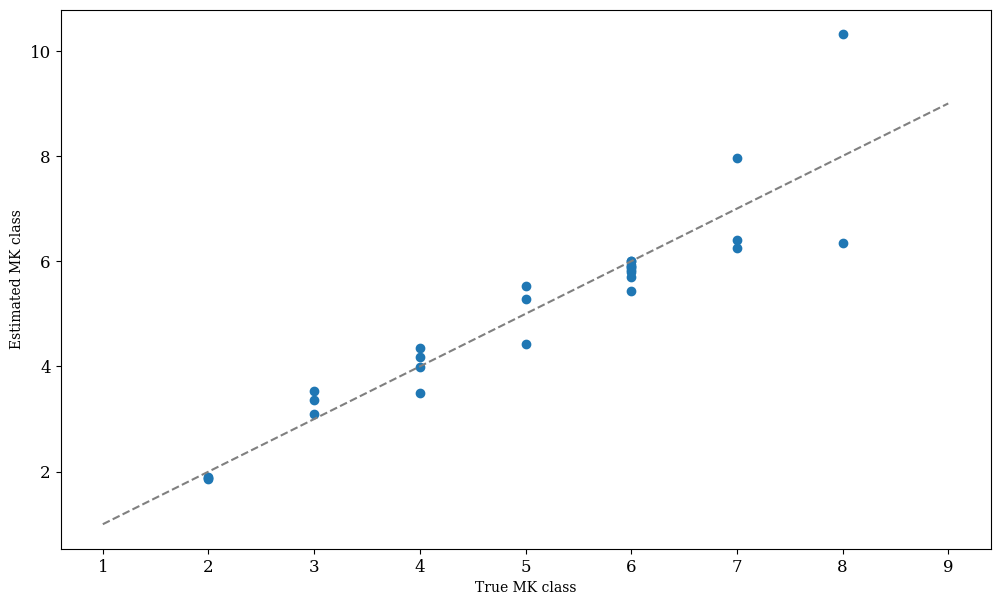

In [21]:
plt.scatter(test_y, y_pred)
plt.plot([1, 9], [1, 9], ls='dashed', color='gray')
plt.xlabel('True MK class')
plt.ylabel('Estimated MK class')
fig = plt.gcf()
fig.set_size_inches(12, 7)

It is usually more useful to look at the residual plot which shows an increasing problem towards K & M classes. This could perfectly well be due to the particular training set (I only used one for now after all!).

Text(0, 0.5, 'True-Estimated class')

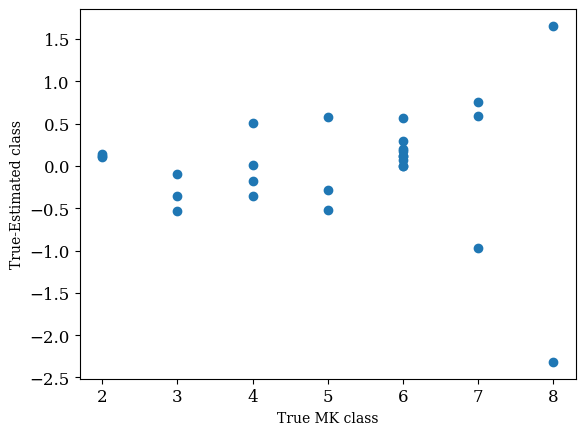

In [22]:
plt.scatter(test_y, test_y-y_pred[:, 0])
plt.xlabel('True MK class')
plt.ylabel('True-Estimated class')